In [149]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator, EMAIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [150]:
data = pd.read_csv('.\data1mins.csv')

In [151]:
data

Loading ITables v2.5.2 from the internet... (need help?)


In [152]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [153]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [154]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2063, 4, 19),
 datetime.date(2070, 2, 20),
 datetime.date(2197, 11, 16),
 datetime.date(2134, 3, 18),
 datetime.date(2183, 10, 16),
 datetime.date(2062, 3, 16),
 datetime.date(2042, 6, 19),
 datetime.date(2196, 6, 16),
 datetime.date(2248, 1, 20),
 datetime.date(2122, 6, 18),
 datetime.date(2253, 11, 17),
 datetime.date(2087, 1, 16),
 datetime.date(2041, 8, 15),
 datetime.date(2022, 12, 15),
 datetime.date(2061, 6, 16),
 datetime.date(2114, 9, 20),
 datetime.date(2243, 12, 21),
 datetime.date(2067, 4, 21),
 datetime.date(2078, 8, 18),
 datetime.date(2205, 10, 17),
 datetime.date(2223, 12, 18),
 datetime.date(2252, 2, 19),
 datetime.date(2241, 8, 19),
 datetime.date(2034, 8, 17),
 datetime.date(2130, 3, 16),
 datetime.date(2113, 1, 19),
 datetime.date(2191, 3, 17),
 datetime.date(2178, 9, 17),
 datetime.date(2083, 8, 19),
 datetime.date(2228, 2, 21),
 datetime.date(2179, 1, 21),
 datetime.date(2183, 3, 20),
 datetime.date(2212, 12, 17),
 datetime.date(2017, 7, 20),
 datet

In [155]:
# AverageTrueRange, CCIIndicator, IchimokuIndicator, MACD, RSI, ADXIndicator, RSI, stochastic,
def alpha(data, params):
    data['Close_filtered'] = lowpass_filter_period_only(data['Close'], params['t1'])

    #tính chỉ báo 
    data['RSI'] = RSIIndicator(close=data['Close'], window = params['w1']).rsi()
    
    data['EMA_short'] = EMAIndicator(close=data['Close'], window=params['ema_short']).ema_indicator()
    data['EMA_long'] = EMAIndicator(close=data['Close'], window=params['ema_long']).ema_indicator()
    data['EMA_long'] = data['EMA_long'].fillna(data['EMA_short'])
    data['CMF'] = ChaikinMoneyFlowIndicator(high=data['High'], low = data['Low'], close = data['Close'], volume=data['Volume'], window = params['chai_win']).chaikin_money_flow()
    data['VMA'] = data['Volume'].rolling(window=params['VMA']).mean()
    threshold_multiplier = 1.1
    data['Signal'] = (data['Volume'] > (data['VMA'] * threshold_multiplier)).astype(int)
    #
    patience = 0
    
    
    pos = 0
    position = []
    for i in range(len(data)):
        #
        
        RSI = data['RSI'].values[i]
        is_uptrend = data['EMA_short'].iloc[i] >= data['EMA_long'].iloc[i]
        is_downtrend = data['EMA_short'].iloc[i] <= data['EMA_long'].iloc[i]
        
        cl_now = data['Close'].iat[i]
        
        signal_in = data['Signal'].iat[i] == 1
        
                
        
        #
        if pos == 0:
            cmf_now = data['CMF'].iloc[i]
            close_filtered = data['Close_filtered'].iloc[i]
            
            # Entry long
            if RSI > params['t3'] and is_uptrend and signal_in and cmf_now > 0 and cl_now > close_filtered:
                pos = 1
            
            # Entry short
            if RSI < params['t2'] and is_downtrend and signal_in and cmf_now < 0 and cl_now < close_filtered:
                pos = -1
        elif pos == 1:
            # Exit long
            if (RSI < params['t5'] or data['EMA_short'].iloc[i] < data['EMA_long'].iloc[i] or data['CMF'].iloc[i] < 0):
                pos = 0

        elif pos == -1:
            # Exit short
            if (RSI > params['t4'] or data['EMA_short'].iloc[i] > data['EMA_long'].iloc[i] or data['CMF'].iloc[i] > 0):
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            #thoát short cuối ngày(CÓ THỂ HOẶC KHÔNG)
            if pos == - 1:
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                #reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0

        position.append(pos)
    #mục đích cuối cùng vẫn là cột pos(position)
    data['pos'] = position
    return data


In [156]:
params = {'t1': 0.75, 't2': 33, 't3': 71, 't4': 43, 't5': 51, 'w1': 10, 'ema_short': 11, 'ema_long': 67, 'chai_win': 8, 'VMA': 10}

In [157]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 8.92
MDD: 79.0 (5.05%)

   Total trading quantity: 1501
         Profit per trade: 1.43
             Total Profit: 2947.5
         Profit after fee: 2140.9
 Trading quantity per day: 0.79
 Profit per day after fee: 1.13
                   Return: 0.18
          Profit per year: 280.99
                  HitRate: 0.46
          HitRate per day: 0.41


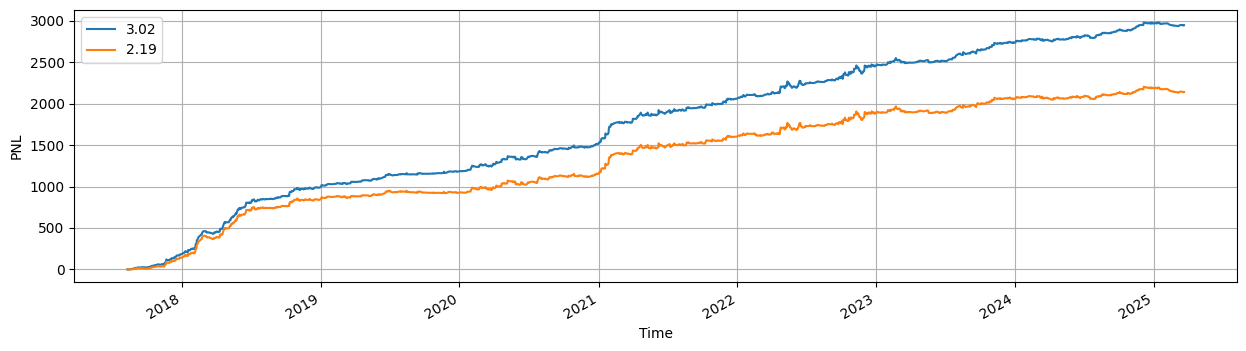

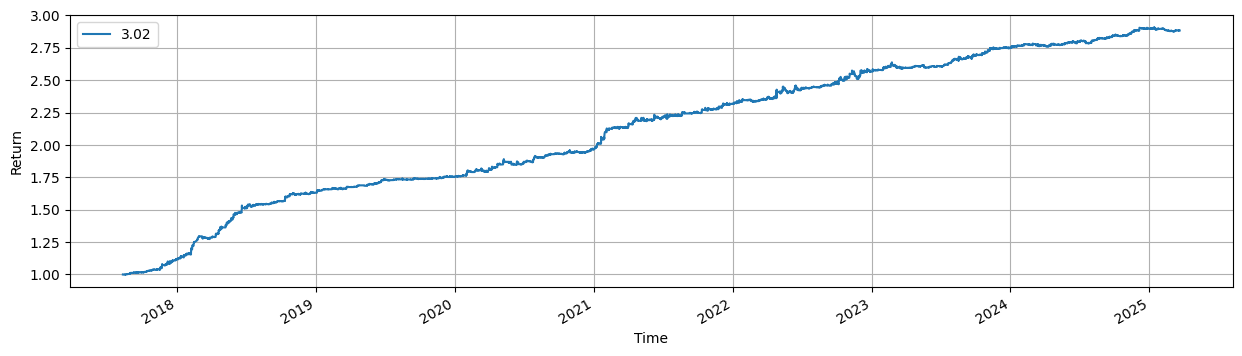

In [158]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [159]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [160]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)


In [161]:
merged = pd.merge(ds, pnl, left_on="Date",right_on= "Datetime", how="inner")
merged

Loading ITables v2.5.2 from the internet... (need help?)


In [162]:
df = pd.DataFrame(ds)

# select Date and pos
df_result = df[["Date", "Close", "pos"]]
df_result['pos_z'] = df_result['pos']
df_result = df_result.drop('pos', axis = 1)
df_result

Loading ITables v2.5.2 from the internet... (need help?)


In [163]:
df_result.to_csv("alpha4_pos.csv", index=False)